<a href="https://colab.research.google.com/github/rahiakela/data-science-research-and-practice/blob/main/data-science-bookcamp/case-study-3--disease-outbreaks/02_geographic_location_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Geographic location analysis

This navigation paradigm perfectly encapsulates the standard data science process. As
data scientists, we are offered raw observations. We algorithmically analyze that data.
Then, we visualize the results to make critical decisions. Thus, data science and location
analysis are linked. That link has only grown stronger through the centuries.

Hedge funds study satellite photos of farmlands to make bets on the
global soybean market. Transport-service providers analyze vast traffic patterns to efficiently
route fleets of cars. Epidemiologists process newspaper data to monitor the
global spread of disease.

In this notebook, we explore a variety of techniques for analyzing and visualizing geographic
locations. We begin with the simple task of calculating the distance between
two geographic points.

##Setup

In [ ]:
!pip -q install cartopy

In [3]:
from collections import defaultdict
import itertools

import numpy as np
import pandas as pd
from scipy import stats
from math import cos, sin, asin
from math import pi

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from scipy.spatial.distance import euclidean
from sklearn.datasets import make_circles

import cartopy
import seaborn as sns
import matplotlib.pyplot as plt

##The great-circle distance

We can compute the great-circle distance given a sphere and two points on that
sphere. 

Any point on the sphere’s surface can be represented using spherical coordinates
x and y, where x and y measure the angles of the point relative to the x-axis and y-axis.

In [4]:
# Defining a great-circle distance function
def great_circle_distance(x1, y1, x2, y2):
  # Computes the angular difference between the two pairs of spherical coordinates
  delta_x, delta_y = x2 - x1, y2 - y1
  haversin = sin(delta_x / 2) ** 2 + np.product([cos(x1), cos(x2), sin(delta_y / 2) ** 2])
  return 2 * asin(haversin ** .5)

Let’s calculate the greatcircle
distance between two points that lie 180 degrees apart relative to both the x-axis
and the y-axis.

In [5]:
# Computing the great-circle distance
distance = great_circle_distance(0, 0, 0, pi)
print(f"The distance equals {distance} units.")

The distance equals 3.141592653589793 units.


That value is the longest possible distance we can travel between two spherical
points. 

This is akin to traveling between the North and South Poles of any planet.

Let’s begin by recording the known coordinates of each pole.

In [6]:
# Defining the coordinates of Earth’s poles
latitude_north, longitude_north = (90.0, 0)
latitude_south, longitude_south = (-90.0, 0)

In [7]:
# Computing the great-circle distance between poles
to_radians = np.radians([latitude_north, longitude_north, latitude_south, longitude_south])
distance = great_circle_distance(*to_radians.tolist())
print(f"The unit-circle distance between poles equals {distance} units.")

The unit-circle distance between poles equals 3.141592653589793 units.


Now, let’s measure the
distance between two poles here on Earth. 

The radius of Earth is not 1 hypothetical
unit but rather 3956 actual miles, so we must multiply distance by 3956 to obtain a
terrestrial measurement.

In [8]:
# Computing the travel distance between Earth’s poles
earth_distance = 3956 * distance
print(f"The distance between poles equals {earth_distance} miles.")

The distance between poles equals 12428.14053760122 miles.


In [9]:
# Defining a travel distance function
def travel_distance(lat1, lon1, lat2, lon2):
  to_radians = np.radians([lat1, lon1, lat2, lon2])
  return 3956 * great_circle_distance(*to_radians.tolist())

assert travel_distance(90, 0, -90, 0) == earth_distance

As discussed, we can pass such metrics into
the DBSCAN clustering algorithm, so we can use `travel_distance` to cluster locations based on their spatial distributions. 

Then we can visually validate the clusters by
plotting the locations on a map. This map plot can be executed using the external `Cartopy` visualization library.

##Plotting maps using Cartopy

The K-means algorithm assumes that inputted data points swirl around K different centers.
Each central coordinate is like a hidden bull’s-eye surrounded by scattered data points. 

The purpose of the algorithm is to uncover these hidden central coordinates.

In [ ]:
# K-means clustering using scikit-learn
cluster_model = KMeans(n_clusters=2)
assigned_bulls_eyes = cluster_model.fit_predict(darts)

print(f"Bull's-eye assignments:")
print(assigned_bulls_eyes)

Bull's-eye assignments:
[0 0 0 ... 1 1 1]


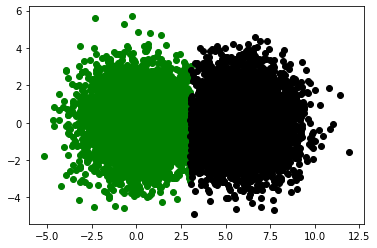

In [ ]:
# Plotting K-means cluster assignments
for bs_index in range(len(bulls_eyes)):
  # Selects the darts most proximate to assigned_bulls_eyes[bs_index]
  selected_darts = [darts[i] for i in range(len(darts)) if bs_index == assigned_bulls_eyes[i]]
  # Separates the x and y coordinates of each dart by transposing an array of selected darts.
  x_coordinates, y_coordinates = np.array(selected_darts).T
  plt.scatter(x_coordinates, y_coordinates, color=["g", "k"][bs_index])
plt.show()

Our clustering model has located the centroids in the data. 

Now we can reuse these
centroids to analyze new data points that the model has not seen before.

In [ ]:
# Using cluster_model to cluster new data
def cluster_data(new_darts):
  new_bulls_eye_assignments = cluster_model.predict(new_darts)
  for i, dart in enumerate(new_darts):
    bulls_eye_index = new_bulls_eye_assignments[i]
    print(f"Dart at {dart} is closest to bull's-eye {bulls_eye_index}")

In [ ]:
new_darts = [[500, 500], [-500, -500]]
cluster_data(new_darts)

Dart at [500, 500] is closest to bull's-eye 1
Dart at [-500, -500] is closest to bull's-eye 0


In [ ]:
new_darts = [[0, 1], [6, 1]]
cluster_data(new_darts)

Dart at [0, 1] is closest to bull's-eye 0
Dart at [6, 1] is closest to bull's-eye 1


In [ ]:
new_darts = [[0.5, 1.5], [6.5, 1.5]]
cluster_data(new_darts)

Dart at [0.5, 1.5] is closest to bull's-eye 0
Dart at [6.5, 1.5] is closest to bull's-eye 1


In [ ]:
new_darts = [[8.5, 3.5], [-3.5, 2.5]]
cluster_data(new_darts)

Dart at [8.5, 3.5] is closest to bull's-eye 1
Dart at [-3.5, 2.5] is closest to bull's-eye 0


###The elbow method

We can, however, estimate an
appropriate value for $K$ using a technique known as the elbow method.

The elbow method depends on a calculated value called inertia, which is the sum of
the squared distances between each point and its closest K-means center.

Basically, inertia estimates total
dispersion around our K computed means.

By estimating dispersion, we can determine whether our K value is too high or too low.

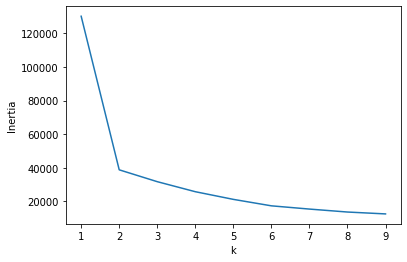

In [ ]:
# Plotting the K-means inertia
k_values = range(1, 10)

inertia_values = [KMeans(k).fit(darts).inertia_ for k in k_values]

plt.plot(k_values, inertia_values)
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

We can find out by adding an additional bull’s-eye to our dart-throwing simulation. 

After we increase the cluster count to 3, we regenerate our inertia plot.

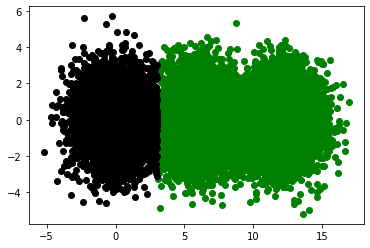

In [ ]:
# Plotting inertia for a 3-dartboard simulation
new_bulls_eye = [12, 0]
for _ in range(5000):
  x = np.random.normal(new_bulls_eye[0], variance ** 0.5)
  y = np.random.normal(new_bulls_eye[1], variance ** 0.5)
  darts.append([x, y])

color_by_cluster(darts)

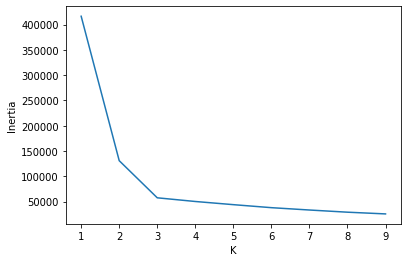

In [ ]:
inertia_values = [KMeans(k).fit(darts).inertia_ for k in k_values]

plt.plot(k_values, inertia_values)
plt.xlabel("K")
plt.ylabel("Inertia")
plt.show()

The elbow method isn’t perfect, but it performs reasonably well if the data is centered on $K$ distinct means. Of course, this assumes that our data clusters differ due to centrality.

However, in many instances, data clusters differ due to the density of the data points in space.

##Using density to discover clusters

Let’s generate three rock rings composed of
many rocks.

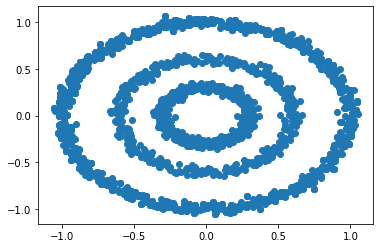

In [ ]:
# Simulating rings around a planet
x_coordinates = []
y_coordinates = []

for factor in [.3, .6, 0.99]:
  rock_ring, _ = make_circles(n_samples=800, factor=factor, noise=0.03, random_state=1)
  for rock in rock_ring:
    x_coordinates.append(rock[0])
    y_coordinates.append(rock[1])
plt.scatter(x_coordinates, y_coordinates)
plt.show()

Let’s search for these three clusters
using K-means by setting `K` to 3.

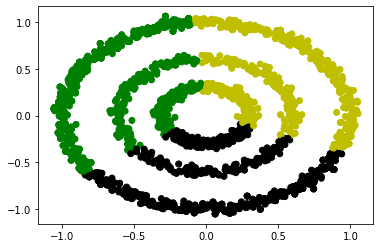

In [ ]:
# Using K-means to cluster rings
rocks = [[x_coordinates[i], y_coordinates[i]] for i in range(len(x_coordinates))]
rock_clusters = KMeans(3).fit_predict(rocks)

colors = [["g", "y", "k"][cluster] for cluster in rock_clusters]
plt.scatter(x_coordinates, y_coordinates, color=colors)
plt.show()

One simple definition of density is as follows: a point is in a dense region only if it’s located within a distance
X of Y other points. 

We’ll refer to X and Y as `epsilon` and `min_points`,
respectively.

In [ ]:
# Specifying density parameters
epsilon = 0.1
min_points = 10

Let’s analyze the density of the first rock in our rocks list.

In [ ]:
# Finding the neighbors of rocks[0]
neighbor_indices = [i for i, rock in enumerate(rocks[1:]) if euclidean(rocks[0], rock) <= epsilon]

Now we compare the number of neighbors to `min_points` to determine whether
`rocks[0]` lies in a dense region of space.

In [ ]:
# Checking the density of rocks[0]
num_neighbors = len(neighbor_indices)
print(f"The rock at index 0 has {num_neighbors} neighbors.")

if num_neighbors >= min_points:
  print(f"It lies in a dense region.")
else:
  print("It does not lie in a dense region.")

The rock at index 0 has 40 neighbors.
It lies in a dense region.


In [ ]:
# Creating a dense cluster
dense_region_indices = [0] + neighbor_indices
dense_region_cluster = [rocks[i] for i in dense_region_indices]
dense_cluster_size = len(dense_region_cluster)
print(f"We found a dense cluster containing {dense_cluster_size} rocks.")

We found a dense cluster containing 41 rocks.


In [ ]:
# Expanding a dense cluster
dense_region_indices = set(dense_region_indices)  # Converts dense_region_indices into a set
for index in neighbor_indices:
  point = rocks[index]
  neighbors_of_neighbors = [i for i, rock in enumerate(rocks) if euclidean(point, rock) <= epsilon]
  if len(neighbors_of_neighbors) >= min_points:
    dense_region_indices.update(neighbors_of_neighbors)

dense_region_cluster = [rocks[i] for i in dense_region_indices]
dense_cluster_size = len(dense_region_cluster)
print(f"We expanded our cluster to include {dense_cluster_size} rocks.")

We expanded our cluster to include 781 rocks.


The procedure just described is known as DBSCAN. The DBSCAN algorithm organizes data based on its spatial distribution.

##DBSCAN algorithm 

DBSCAN is an acronym that stands for density-based spatial clustering of applications with noise.

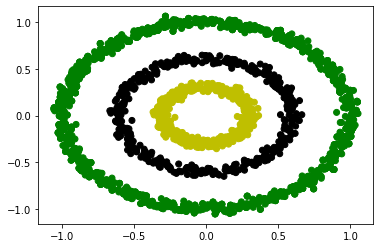

In [ ]:
# Using DBSCAN to cluster rings
cluster_model = DBSCAN(eps=epsilon, min_samples=min_points)
# Clusters the rock rings based on density
rock_clusters = cluster_model.fit_predict(rocks)

colors = [["g", "y", "k"][cluster] for cluster in rock_clusters]
plt.scatter(x_coordinates, y_coordinates, color=colors)
plt.show()

###Comparing DBSCAN and K-means

DBSCAN is an advantageous algorithm for clustering data composed of curving and
dense shapes. Also, unlike K-means, the algorithm doesn’t require an approximation
of the cluster count before execution. 

Additionally, DBSCAN can filter random outliers
located in sparse regions of space.

In [ ]:
# Finding outliers using DBSCAN
noisy_data = rocks + [[1000, -1000]]

clusters = DBSCAN(eps=epsilon, min_samples=min_points).fit_predict(noisy_data)
assert clusters[-1] == -1

Another advantage of the DBSCAN technique is that it does not depend on the mean.

###Clustering based on non-Euclidean distance

In [ ]:
# Computing the Manhattan distance
def manhattan_distance(point_a, point_b):
  num_blocks = np.sum(np.absolute(point_a - point_b))
  return 0.17 * num_blocks

In [ ]:
x = np.array([34, 5])
y = np.array([57, 8])

distance = manhattan_distance(x, y)
print(f"Manhattan distance is {distance} miles.")

Manhattan distance is 4.42 miles.


Point at index 0 is in cluster 0
Point at index 1 is in cluster 0
Point at index 2 is in cluster 0
Point at index 3 is an outlier
Point at index 4 is an outlier


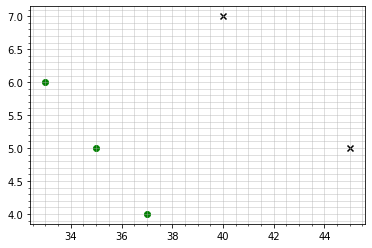

In [ ]:
# Clustering using Manhattan distance
points = [[35, 5], [33, 6], [37, 4], [40, 7], [45, 5]]
clusters = DBSCAN(eps=1, min_samples=3, metric=manhattan_distance).fit_predict(points)
for i, cluster in enumerate(clusters):
  point = points[i]
  if cluster == -1:
    print(f"Point at index {i} is an outlier")
    plt.scatter(point[0], point[1], marker="x", color="k")
  else:
    print(f"Point at index {i} is in cluster {cluster}")
    plt.scatter(point[0], point[1], color="g")

# displays the rectangular grid
plt.grid(True, which="both", alpha=0.5)
plt.minorticks_on()
plt.show()

Unlike K-means, the DBSCAN algorithm does not require our distance function to be
linearly divisible. 

Thus, we can easily run DBSCAN clustering using our ridiculous distance
metric.

In [ ]:
# Clustering using a ridiculous measure of distance
def ridiculous_measure(point_a, point_b):
  # Returns a Boolean array
  is_negative_a = np.array(point_a) < 0
  is_negative_b = np.array(point_b) < 0

  # All elements of point_a and point_b are negative
  if is_negative_a.all() and is_negative_b.all():
    return 0
  elif is_negative_a.any() and is_negative_b.any():  # A negative element exists, but not all elements are negative
    return 10
  else:  # All elements are non-negative
    return 2

In [ ]:
points = [[-1, -1], [-10, -10], [-1000, -13435], [3, 5], [5, -7]]
clusters = DBSCAN(eps=.1, min_samples=2, metric=ridiculous_measure).fit_predict(points)
for i, cluster in enumerate(clusters):
  point = points[i]
  if cluster == -1:
    print(f"{point} is an outlier")
  else:
    print(f"{point} falls in cluster {cluster}")

[-1, -1] falls in cluster 0
[-10, -10] falls in cluster 0
[-1000, -13435] falls in cluster 0
[3, 5] is an outlier
[5, -7] is an outlier


DBSCAN does have certain drawbacks. The algorithm is intended to detect clusters
with similar point-density distributions. However, real-world data varies in density.

This highlights another limitation of
the algorithm: DBSCAN requires meaningful values for the eps and min_samples
parameters. In particular, varying eps inputs will greatly impact the quality of clustering.
Unfortunately, there is no one reliable procedure for estimating the appropriate
eps.

##Analyzing clusters using Pandas

Our Pandas table lets us easily access the rocks in any cluster.

In [ ]:
# Storing clustered coordinates in a table
x_coordinates, y_coordinates = np.array(rocks).T

df = pd.DataFrame({"X": x_coordinates, "Y": y_coordinates, "Cluster": rock_clusters})

Let’s plot the rocks that
fall into cluster 0.

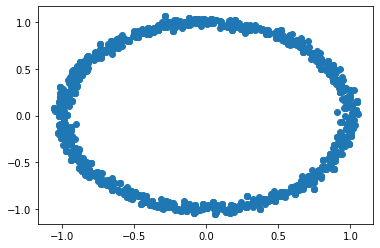

In [ ]:
# Plotting a single cluster using Pandas

# Select just those rows where the Cluster column equals 0
df_cluster = df[df.Cluster == 0]
plt.scatter(df_cluster.X, df_cluster.Y)
plt.show()

Skipping over cluster 0
Plotting cluster 1
Plotting cluster 2


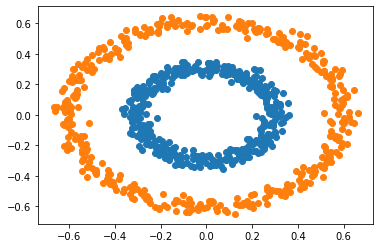

In [ ]:
# Iterating over clusters using Pandas
for cluster_id, df_cluster in df.groupby("Cluster"):
  if cluster_id == 0:
    print(f"Skipping over cluster {cluster_id}")
    continue
  print(f"Plotting cluster {cluster_id}")
  plt.scatter(df_cluster.X, df_cluster.Y)
plt.show()

The Pandas groupby method lets us iteratively examine different clusters.